In [1]:
import control as ct
import control2020 as ct20
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
s = ct.TransferFunction([1, 0], [1])

## Examen final - Control automático
### Alumno: Bregy Malpartida
**Disclaimer**: Inicialmente tenia la intencion de no poner el código de las funciones que construí previamente para este examen, sin embargo, tuve un problema de último momento con los paquetes de python ([pip](https://pypi.org/project/control2020)) y finalmente me vi forzado a colocar el código de las funciones. Espero que eso no impida la lectura de la resolución del examen, si ese es el caso, estaré atento para responder a cualquier duda.

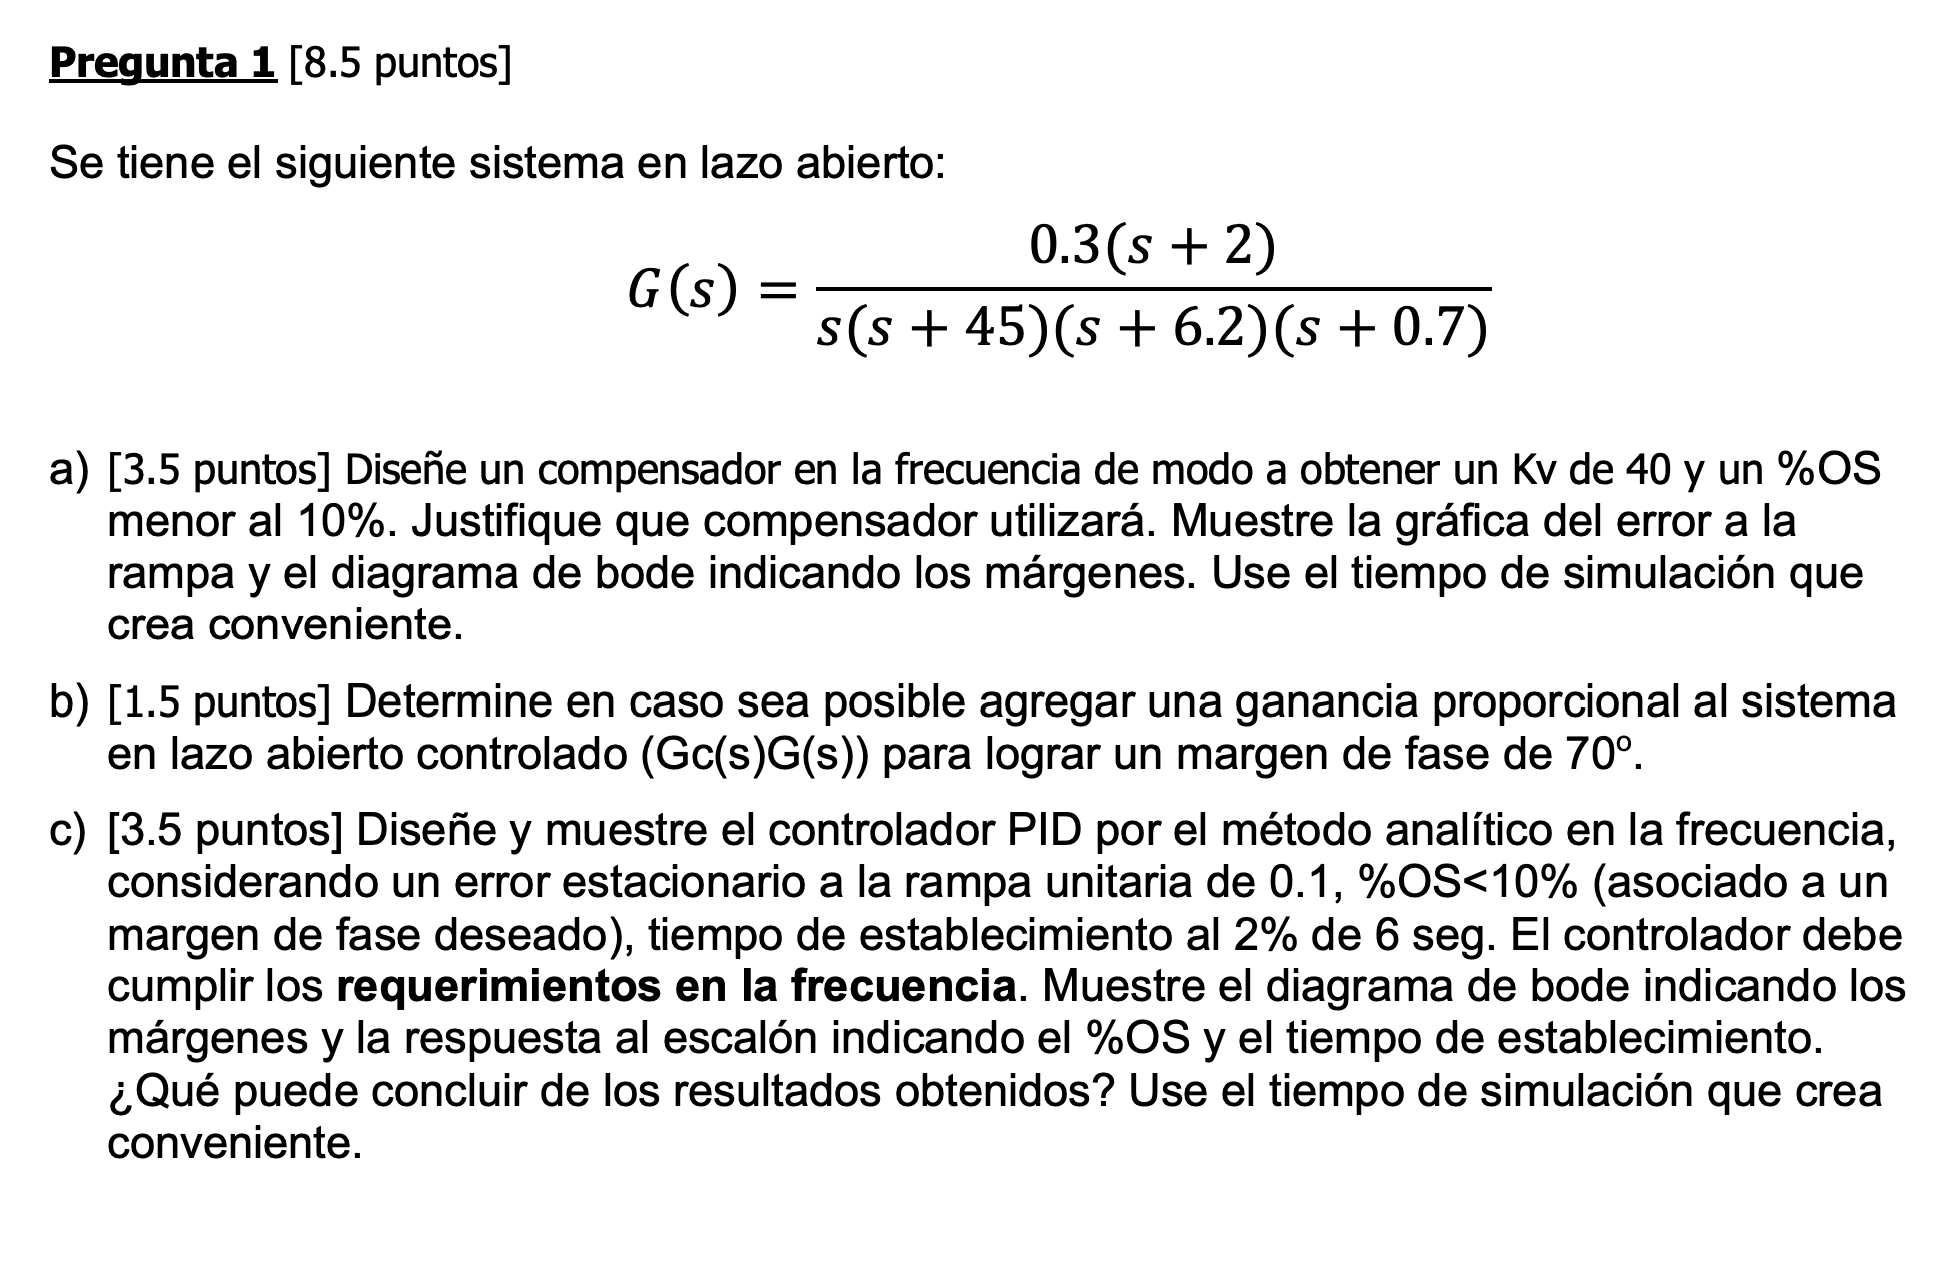

---

###  Diseñe un compensador en la frecuencia de modo a obtener un Kv de 40 y un %OS menor al 10%. Justifique que compensador utilizará. Muestre la gráfica del error a la rampa y el diagrama de bode indicando los márgenes. Use el tiempo de simulación que crea conveniente.

In [7]:
g = ct.minreal(0.3*(s+2)/s/(s+45)/(s+6.2)/(s+0.7))
display(g)

0 states have been removed from the model



            0.3 s + 0.6
------------------------------------
s^4 + 51.9 s^3 + 314.8 s^2 + 195.3 s

Graficando el diagrama de bode

(36176.35435295296, 89.80424986805895, 14.590232371449993, 0.0030721702733137435)


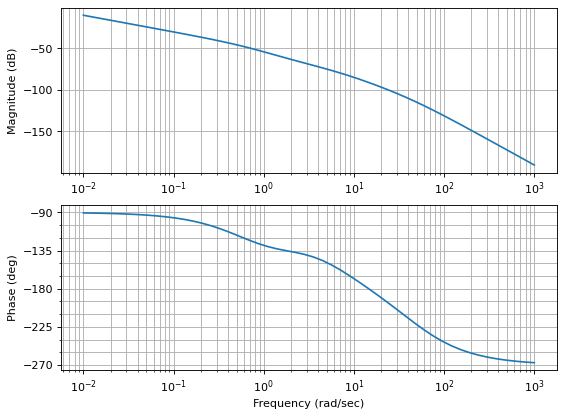

In [11]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
_ = ct.bode(g, dB=True)
print(ct.margin(g))

In [18]:
po = 10
kv = 40
err_ramp_expected = 1/kv

log_po = np.log(100 / po)
psi = log_po / np.sqrt(np.pi ** 2 + log_po ** 2)
print(psi)
print("Phase Margin=",100*psi)
print("Ramp error ss=", err_ramp_expected)

0.5911550337988976
Phase Margin= 59.11550337988976
Ramp error ss= 0.025


Como vemos, necesitamos un margen de fase de al menos 59deg, teniendo en cuenta que el margen de fase actual es de 89deg, usaré un lag compensator.

In [17]:
def ss_error(g, err_step=None, err_ramp=None, err_para=None):
    s = ct.TransferFunction([1, 0], [1])
    kx = None
    ess = None
    if err_step is not None:
        ess = ct.evalfr(ct.minreal(g), 0j)
        kx = 1 / err_step
    elif err_ramp is not None:
        ess = ct.evalfr(ct.minreal(s*g), 0j)
        kx = 1 / err_ramp
    elif err_para is not None:
        ess = ct.evalfr(ct.minreal(g/s), 0j)
        kx = 1 / err_para

    return kx, ess


def lag_compensator(g, err_step=None, err_ramp=None, err_para=None, pm_desired=None, psi=None):
    s = ct.TransferFunction([1, 0], [1])
    if psi is not None:
        pm_desired = 100 * psi * np.pi / 180

    if pm_desired > 2 * np.pi:
        print("remember, I need phase in radians")

    kc, ess = ss_error(g, err_step, err_ramp, err_para)

    if abs(ess) == np.inf or abs(ess) == np.nan:
        ess = None

    if ess is None or kc is None:
        assert "Inconsistent system"

    kc = kc / np.real(ess)

    print("kc=", kc)

    phi = (pm_desired + 7 * np.pi / 180) - np.pi

    print("phi=", phi)

    mag, phase, omega = ct.bode(kc * g, Plot=False)
    arg = np.argmin(abs(phase - phi))

    wcg = omega[arg]
    print(f"wcg= {wcg}")

    gain = 20 * np.log10(mag[arg])
    a = 0 - gain
    print(f"A= {a}")

    alpha = 10 ** (a / 20)
    tau = 10 / alpha / wcg

    lag = kc * (alpha * tau * s + 1) / (tau * s + 1)

    return lag

In [20]:
compensator = lag_compensator(g, err_ramp=err_ramp_expected, psi=psi)
display(compensator)

1 states have been removed from the model
kc= 13019.999999999995
phi= -1.9876594329972777
wcg= 0.42919342601287785
A= -38.17654153620823



3.034e+05 s + 1.302e+04
-----------------------
      1889 s + 1

Veamos los margenes que genera el compensador

gm= 222.97527450706173 | pm= 60.40088255697981


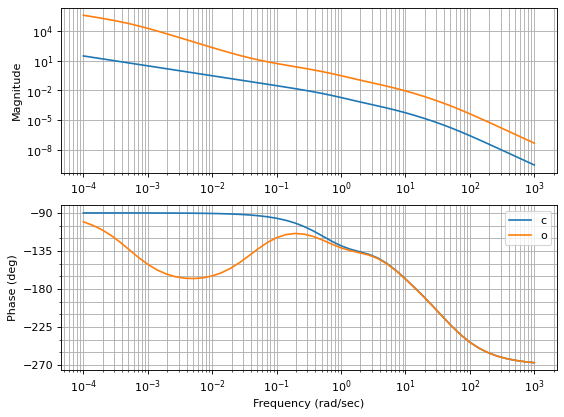

In [90]:
gm, pm, _, _ = ct.margin(g*compensator)
print("gm=",gm,"|", "pm=",pm)
plt.figure(num=None, figsize=(8, 6), dpi=80)
_ = ct.bode(g, omega=np.logspace(-4, 3))
_ = ct.bode(g*compensator, omega=np.logspace(-4, 3))
plt.legend("sin compesador")
plt.legend("cont compesador")

Como se puede apreciar, el compensador consiguio un margen de fase de 60 que esta muy cercano a lo que necesitabamos (59.11)

A continuación veamos la grafica del error a la rampa

0.02518515350158168


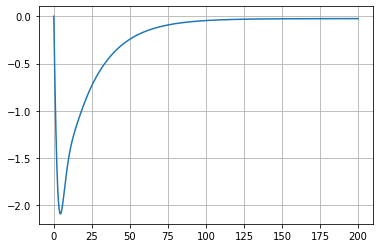

In [37]:
sys = ct.feedback(g*compensator, 1)

t = np.linspace(0, 200, 1000)
u = t

t, y, _ = ct.forced_response(sys, t, u)
error = y - u

print(abs(error[-1]))
plt.plot(t, error)
plt.grid()

Como se puede apreciar en la gráfica del error a la rampa, para un tiempo de 200 segundos (aproximadamente) el error se estabiliza en 0.025 (1/40), lo cual cumple con el requerimiento.

---

### Determine en caso sea posible agregar una ganancia proporcional al sistema en lazo abierto controlado (Gc(s)G(s)) para lograr un margen de fase de 70deg.

In [74]:
def frequency_requirements(g, gain_margin=None, phase_margin=None):
    gains = []

    gm, pm, _, _ = ct.margin(g)
    if gain_margin is not None:
        gains.append(10 ** (-(gain_margin - gm) / 20))

    if phase_margin is not None:
        mag, phase, omega = ct.bode(g, Plot=False)
        arg = np.argmin(abs(phase - (phase_margin - np.pi)))
        m = 20 * np.log10(mag[arg])
        gains.append(10 ** (-m / 20))

    return np.prod(gains)

In [86]:
gm, pm, _, _ = ct.margin(g*compensator)
print("pm=", pm)

pm= 60.40088255697981


Para este problema usaré mi función "frequency_requirements" que en función de los requerimientos de margenes calcula una ganancia proporcional para el sistema. En este caso, especificamente nos piden un margen de fase de 70deg, por lo tanto se ubicará la magnitud que coincide en la frecuencia que satisface el requisito de pm. Veamos.

In [92]:
sys_open_loop = g*compensator
gain = frequency_requirements(sys_open_loop, phase_margin=70*np.pi/180)
print(gain)
gm, pm, _, _ = ct.margin(gain*sys_open_loop)
print("pm=", pm)

5.415832845799026e-06
pm= 69.3401355582231


Como se puede apreciar, con una ganancia de ~5.4e-6 se consigue un pm de 69deg, no es lo que pide el problema con exactitud, pero esta muy cerca, solo haciendo algunos ajustes se puede conseguir el valor de 70deg exactos.

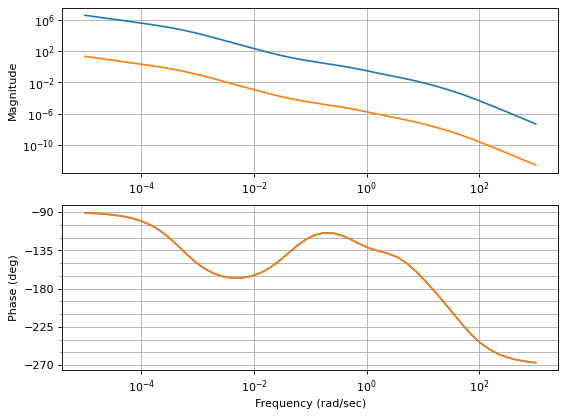

In [93]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
_ = ct.bode(sys_open_loop)
_ = ct.bode(gain*sys_open_loop)

Con una ganancia de 5.415e-6 se consigue el margen de fase esperado.

Como se puede ver, la ganancia escogida deplaza el cruce en cero de la magnitud (ancho de banda) a la izquierda consiguiendo el requerimiento de 70deg.

---

### Diseñe y muestre el controlador PID por el método analítico en la frecuencia, considerando un error estacionario a la rampa unitaria de 0.1, %OS<10% (asociado a un margen de fase deseado), tiempo de establecimiento al 2% de 6 seg. El controlador debe cumplir los requerimientos en la frecuencia. Muestre el diagrama de bode indicando los márgenes y la respuesta al escalón indicando el %OS y el tiempo de establecimiento. ¿Qué puede concluir de los resultados obtenidos? Use el tiempo de simulación que crea conveniente.

In [160]:
def pid_by_frequency(g, po, ts, err_step=None, err_ramp=None, err_para=None):
    s = ct.TransferFunction([1, 0], [1])
    ki = None
    if err_step != None:
        ess = ct.minreal(g/s).evalfr(0)[0][0]
        ki = 1/err_step
    elif err_ramp != None:
        ess = ct.minreal(g).evalfr(0)[0][0]
        ki = 1/err_ramp
    elif err_para != None:
        ess = ct.minreal(s*g).evalfr(0)[0][0]
        ki = 1/err_para
        
    if abs(ess) == np.inf or abs(ess) == np.nan:
        ess = None

    if ess is None or ki is None:
        raise BaseException("Inconsistent system")

    ki = ki / np.real(ess)
    print("ki=", ki)
    
    log_po = np.log(100 / po)
    psi = log_po / np.sqrt(np.pi ** 2 + log_po ** 2)

    wn = 4 / psi / ts
    print("wn=", wn, "psi=", psi)

    pm = 100 * psi
    wcp = wn

    p_cut = ct.evalfr(g, wcp * 1j)
    p_cut_mag = np.abs(p_cut)
    p_cut_angle = np.angle(p_cut)

    controller_mag = 1 / p_cut_mag
    controller_angle = -np.pi + pm * np.pi / 180 - p_cut_angle

    kp = controller_mag * np.cos(controller_angle)
    kd = (controller_mag * np.sin(controller_angle) + ki / wcp) / wcp

    print(f"pm= {pm}, ki= {ki}, kp= {kp}, kd= {kd}")
    controller = kp + kd * s + ki / s

    return controller

Recordemos el sistema inicial G(s)

In [161]:
display(g)


            0.3 s + 0.6
------------------------------------
s^4 + 51.9 s^3 + 314.8 s^2 + 195.3 s

In [162]:
pid = pid_by_frequency(g, po=10, ts=6, err_para=0.1)
display(pid)

1 states have been removed from the model
ki= 3254.9999999999986
wn= 1.127735752130053 psi= 0.5911550337988976
pm= 59.11550337988976, ki= 3254.9999999999986, kp= 607.7839008846936, kd= 2650.6835926339145



2651 s^2 + 607.8 s + 3255
-------------------------
            s

Como se puede apreciar, para los requerimientos propuestos (po=10%, ts=6) se calculó un margen de fase necesario de 59deg.

A continuación se muestra el diagrama de bode y el margen de fase conseguido por el sistema pid\*g (en lazo abierto)

pm= 58.15365437438794


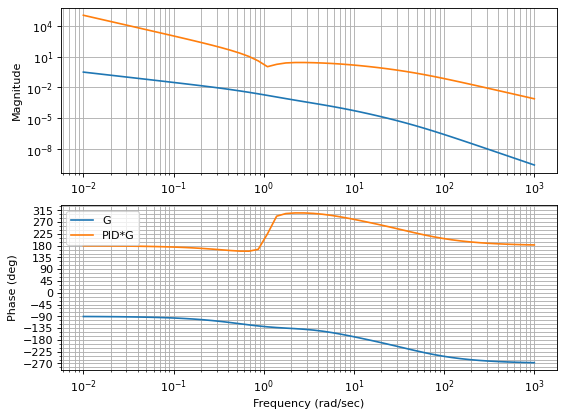

In [172]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
_ = ct.bode(g)
_ = ct.bode(pid*g)
plt.legend(["G", "PID*G"])
_, pm, _, _ = ct.margin(pid*g)
print("pm=", pm)

El margen de fase conseguido (pm=58.1536) es muy cercano al esperado (59.11)

A continuación veremos los resultados conseguidos para el tiempo de establecimiento y porcentaje de overshoot. He intentado bastante tunear, sin embargo, se me ha complicado conseguir los requisitos propuestos por el problema, más abajo haré un analisis de porque creo que es muy complicado conseguir los requerimientos impuestos. 

Cabe resaltar que como vimos arriba, el controlador **sí** ccumple con los requisitos en frecuencia.

{'RiseTime': 0.49378942410249893,
 'SettlingTime': 48.391363562044894,
 'SettlingMin': 0.8671594374316107,
 'SettlingMax': 1.1493524499650172,
 'Overshoot': 14.94041454227027,
 'Undershoot': 0.0,
 'Peak': 1.1493524499650172,
 'PeakTime': 2.3043506458116614,
 'SteadyStateValue': 0.9999550241245506}

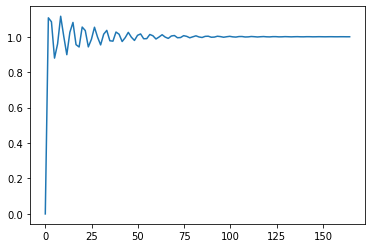

In [170]:
sys_closed_loop = ct.feedback(pid*g, 1)
plt.plot(*ct.step_response(sys_closed_loop))
ct.step_info(sys_closed_loop)

Directamente, usando po=10 y ts=6 no pude conseguir dichos valor, conseguí un po=14.9 (1.5 veces más) y un ts=48 (8 veces más).

0.12595510040409863


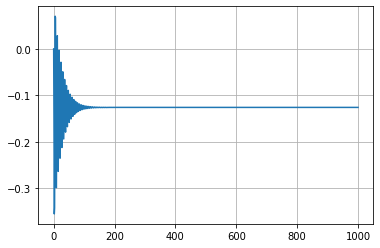

In [180]:
t = np.linspace(0, 1000, 1000)
u = t**2

t, y, _ = ct.forced_response(sys_closed_loop, t, u)
error = y - u

print(abs(error[-1]))
plt.plot(t, error)
plt.grid()

Como se puede apreciar en la gráfica de error( arriba), el error a la parabola en estado estable es de aproximadamente 0.12, el requerimiento era de 0.10, no está muy alejado, pero de todas formas no cumple estrictamente el requerimiento.

---

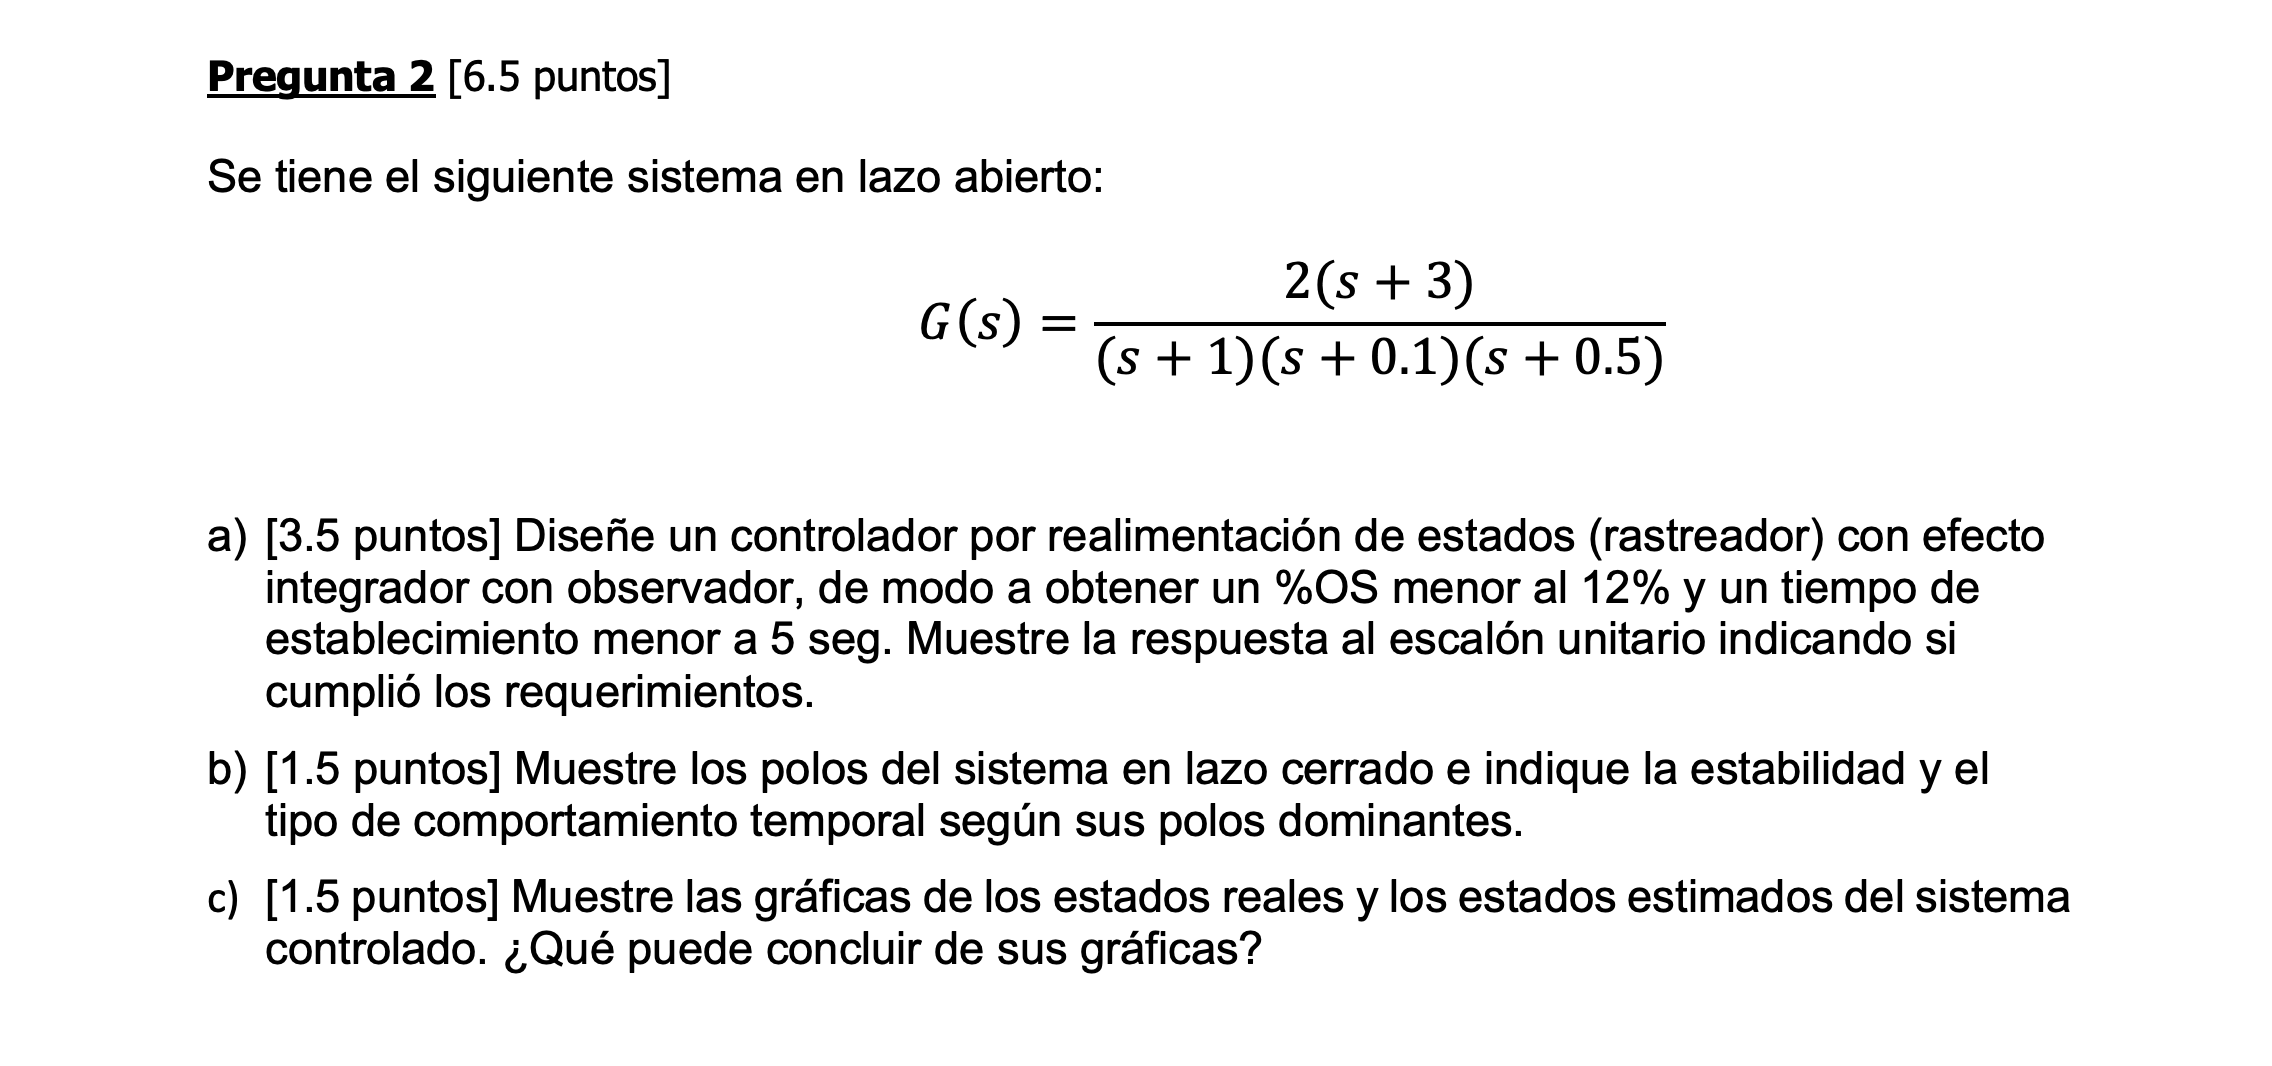

In [182]:
g = 2*(s+3)/(s+1)/(s+0.1)/(s+0.5)
display(g)


           2 s + 6
-----------------------------
s^3 + 1.6 s^2 + 0.65 s + 0.05

### Diseñe un controlador por realimentación de estados (rastreador) con efecto integrador con observador, de modo a obtener un %OS menor al 12% y un tiempo de establecimiento menor a 5 seg. Muestre la respuesta al escalón unitario indicando si cumplió los requerimientos.

In [224]:
def states_tracker(sys, poles=None, po=None, ts=None, extra_poles=[]):
    pa = np.concatenate([sys.A, np.zeros(shape=(sys.A.shape[0], 1))], axis=1)
    pb = np.concatenate([-sys.C, [[0]]], axis=1)

    ao = np.concatenate([pa, pb])
    bo = np.concatenate([sys.B, [[1e-8]]])

    mc = ct.ctrb(ao, bo)

    rank = np.linalg.matrix_rank(mc)

    print(f"rank= {rank}")
    if rank < sys.A.shape[0]:
        raise BaseException("invalid matrix, it's not full controllable")

    final_poles = []

    if poles is not None:
        final_poles = poles

    if po is not None and ts is not None:
        log_po = np.log(100 / po)
        psi = log_po / np.sqrt(np.pi ** 2 + log_po ** 2)
        wn = 4 / psi / ts

        s1 = -psi * wn + 1j * wn * np.sqrt(1 - psi ** 2)
        s2 = -psi * wn - 1j * wn * np.sqrt(1 - psi ** 2)

        final_poles.append(s1)
        final_poles.append(s2)

    for p in extra_poles:
        final_poles.append(p)

    total_poles = len(final_poles)

    if total_poles < rank:
        raise BaseException(f"you have {total_poles} but you need {rank} to implement a FSFB")

    kk = ct.acker(ao, bo, final_poles)
    k = kk[0, :sys.A.shape[0]]
    ki = -kk[0, -1]

    print("k=", k)
    print("ki=", ki)

    pa = np.concatenate([sys.A - sys.B * k, sys.B * ki], axis=1)
    pb = np.concatenate([-sys.C, [[1e-6]]], axis=1)

    ak = np.concatenate([pa, pb], axis=0)
    bk = np.concatenate([np.zeros((sys.A.shape[0], 1)), [[1]]])
    ck = np.concatenate([sys.C, [[1e-6]]], axis=1)
    dk = np.array([[0]])
    
    mo = ct.obsv(sys.A, sys.C);
    obs_rank = np.linalg.matrix_rank(mo)
    
    print("obs_rank=", obs_rank)

    final_poles_obs = 5*final_poles[:-1]

    L = ct.acker(sys.A.T, sys.C.T, final_poles_obs)
    L = L.T
    print("")
    print("L=")
    print(L)
    
    pa = np.concatenate([sys.A, - sys.B * k, sys.B * ki], axis=1)
    pb = np.concatenate([L*sys.C, sys.A-sys.B*k-L*sys.C, sys.B*ki], axis=1)
    pc = np.concatenate([-sys.C, np.zeros((1,sys.A.shape[0])), [[0]]], axis=1)
    
    alc = np.concatenate([pa, pb, pc], axis=0)
    blc = np.concatenate([np.zeros((sys.A.shape[0], 1)), np.zeros((sys.A.shape[0], 1)), [[1]]])
    clc = np.concatenate([sys.C, np.zeros((1,sys.A.shape[0])), [[1e-6]]], axis=1)
    dlc = np.array([[0]])
    
    return ct.ss(alc, blc, clc, dlc)

Primero, veamos el sistema G(s) en su forma de espacio de estados

In [226]:
sys = ct.tf2ss(g)
print("A=")
print(sys.A)
print("")
print("B=")
print(sys.B)
print("")
print("C=")
print(sys.C)
print("")
print("D=")
print(sys.D)

A=
[[-1.6  -0.65 -0.05]
 [ 1.    0.    0.  ]
 [ 0.    1.    0.  ]]

B=
[[1.]
 [0.]
 [0.]]

C=
[[0. 2. 6.]]

D=
[[0.]]


A continuación, construiremos el sistema en lazo cerrado con observador, para po=10 y ts=5, además, como el sistema requiere de dos polos adicionales situaré estos en -10 y -15

In [227]:
# po < 12% -> po=10, ts=5
close_loop_system_w_obs = states_tracker(sys, po=10, ts=5, extra_poles=[-10, -15])

rank= 4
k= [[ 25.00000046 191.18137535 194.16563493]]
ki= 45.784365362579464
obs_rank= 3

L=
[[ 32168.61771761]
 [-20425.76308662]
 [437596.78197928]]


Como se puede ver, la matriz L, corresponde al observador generado

Veamos como quedaron las matrices del sistema final en lazo cerrado con el rastreador y observador:

In [229]:
close_loop_system_w_obs

A = [[-1.60000000e+00 -6.50000000e-01 -5.00000000e-02 -2.50000005e+01
  -1.91181375e+02 -1.94165635e+02  4.57843654e+01]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.43372354e+04  1.93011706e+05 -2.66000005e+01
  -6.45290668e+04 -1.93205922e+05  4.57843654e+01]
 [ 0.00000000e+00 -4.08515262e+04 -1.22554579e+05  1.00000000e+00
   4.08515262e+04  1.22554579e+05  0.00000000e+00]
 [ 0.00000000e+00  8.75193564e+05  2.62558069e+06  0.00000000e+00
  -8.75192564e+05 -2.62558069e+06  0.00000000e+00]
 [-0.00000000e+00 -2.00000000e+00 -6.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]]

B = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]

C = [[0.e+00 2.e+00 6.e+00 0.e+00 0.e+00 0.e+00 1.e-06]]

D = [[0.]]

Ok, para construir el rastreador con observador

{'RiseTime': 1.2082024180570792,
 'SettlingTime': 4.166521574035074,
 'SettlingMin': 0.9017328666686885,
 'SettlingMax': 1.1130772277547296,
 'Overshoot': 11.202347472262188,
 'Undershoot': 0.0,
 'Peak': 1.1130772277547296,
 'PeakTime': 2.638500868845239,
 'SteadyStateValue': 1.0009475996290191}

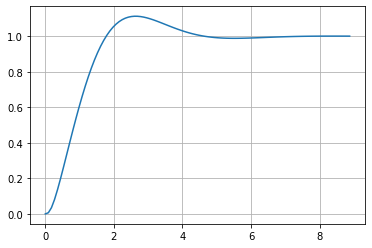

In [232]:
plt.plot(*ct.step_response(close_loop_system_w_obs))
plt.grid()
ct.step_info(close_loop_system_w_obs)

Como se puede apreciar, la respues al escalon cumple con los requerimientos esperados en tiempo po=11.2 (<12) y ts=4 (<5).

Ademas, podemos apreciar que los polos están situados en donde queríamos. (siguiente pregunta)

---

### Muestre los polos del sistema en lazo cerrado e indique la estabilidad y el tipo de comportamiento temporal según sus polos dominantes.

In [1]:
_ = ct.damp(close_loop_system_w_obs)

NameError: name 'ct' is not defined

Es sistema es estable y presenta un comportamiento del tipo amortiguado gracias a los polos complejos conjugados (que son los dominnates)

---

### Muestre las gráficas de los estados reales y los estados estimados del sistema controlado. ¿Qué puede concluir de sus gráficas?

In [237]:
# TODO

---

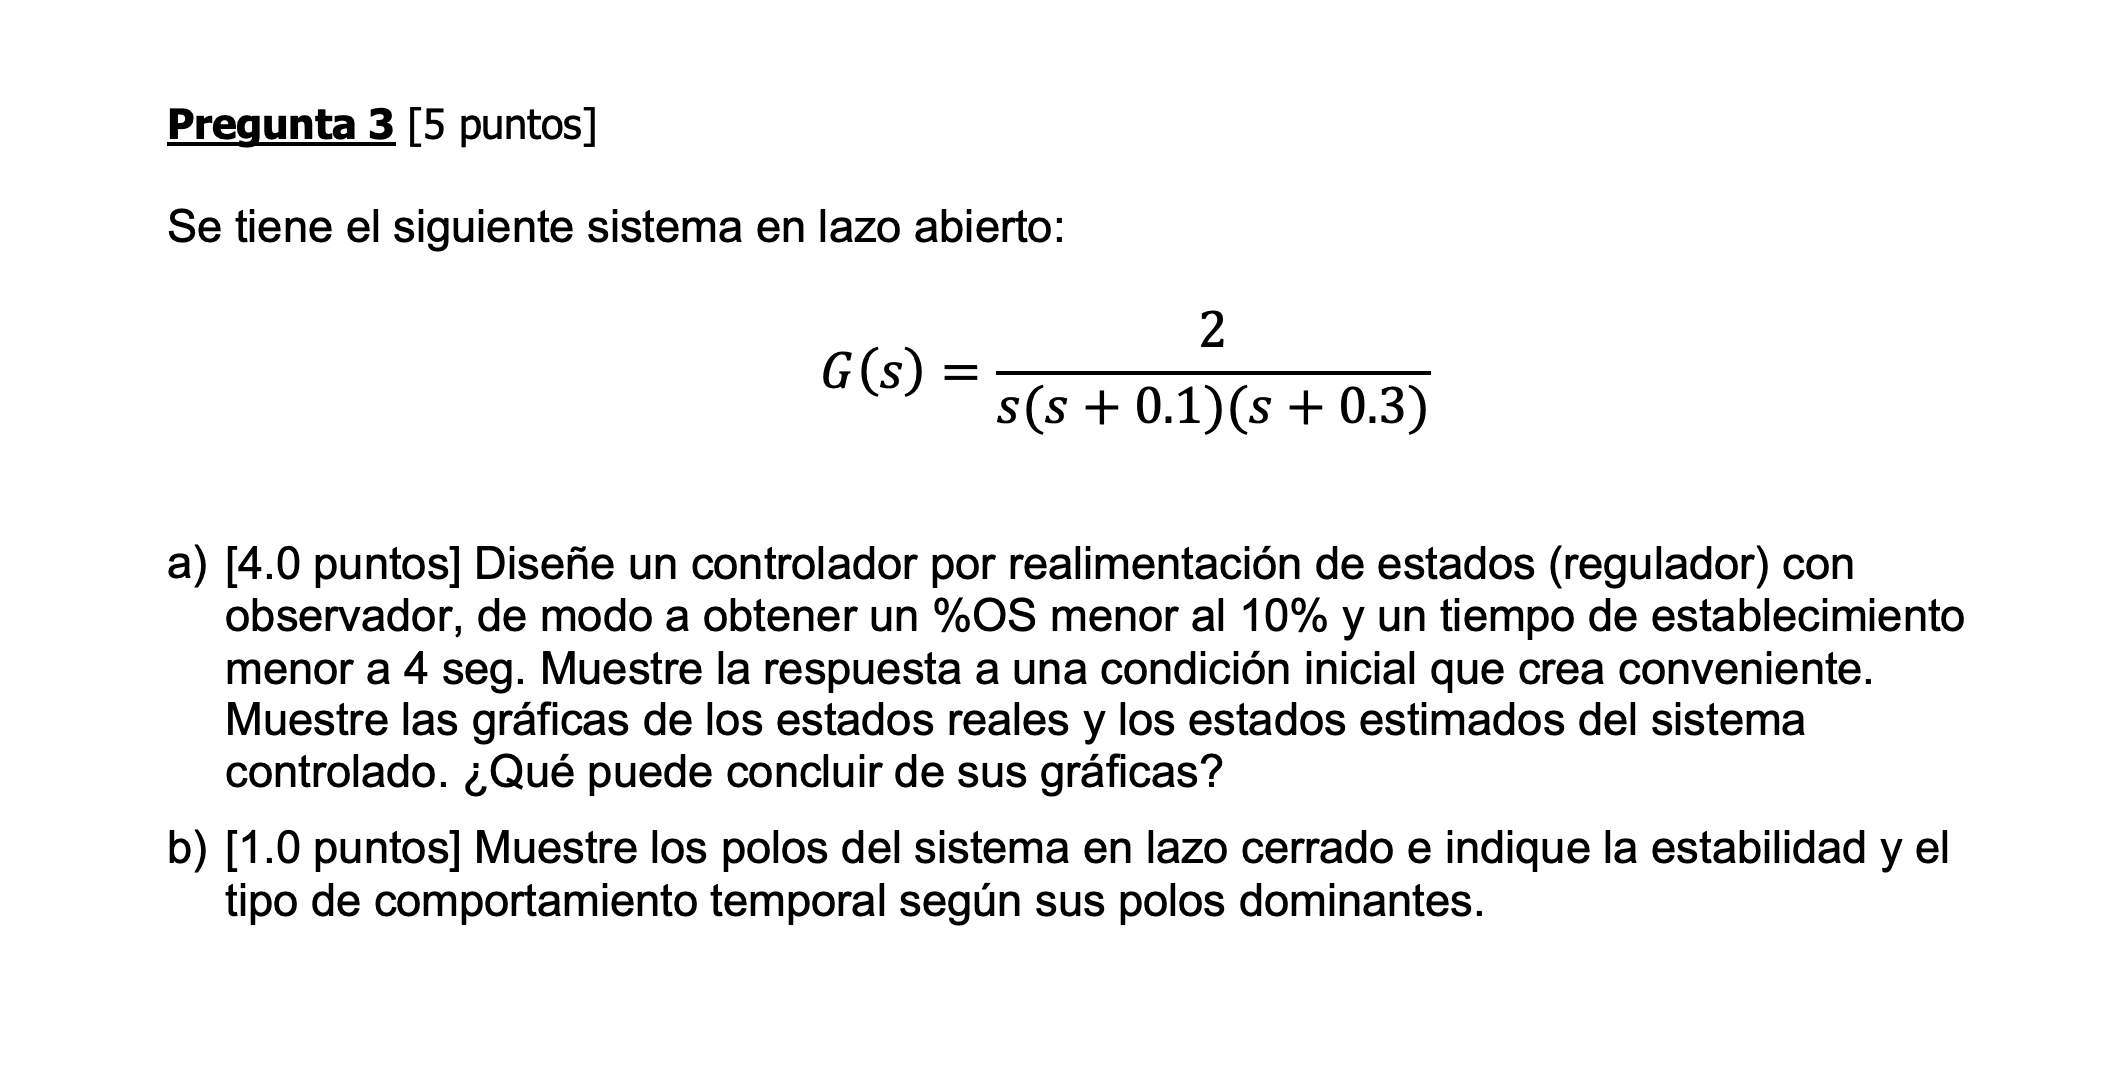

In [240]:
g = 2/s/(s+0.1)/(s+0.3)
display(g)


          2
----------------------
s^3 + 0.4 s^2 + 0.03 s

### Diseñe un controlador por realimentación de estados (regulador) con observador, de modo a obtener un %OS menor al 10% y un tiempo de establecimiento menor a 4 seg. Muestre la respuesta a una condición inicial que crea conveniente. Muestre las gráficas de los estados reales y los estados estimados del sistema controlado. ¿Qué puede concluir de sus gráficas?

In [259]:
def regulator_w_obs(sys, poles=None, po=None, ts=None, extra_poles=[], ck=[]):
    final_poles = []

    if poles is not None:
        final_poles = poles

    if po is not None and ts is not None:
        log_po = np.log(100 / po)
        psi = log_po / np.sqrt(np.pi ** 2 + log_po ** 2)
        wn = 4 / psi / ts

        s1 = -psi * wn + 1j * wn * np.sqrt(1 - psi ** 2)
        s2 = -psi * wn - 1j * wn * np.sqrt(1 - psi ** 2)

        final_poles.append(s1)
        final_poles.append(s2)

    for p in extra_poles:
        final_poles.append(p)

    rank = np.linalg.matrix_rank(ct.ctrb(sys.A, sys.B))

    total_poles = len(final_poles)

    if total_poles < rank:
        raise BaseException(f"you have {total_poles} but you need {rank} to implement a FSFB")

    k = ct.acker(sys.A, sys.B, final_poles)

#     ak = sys.A - sys.B * kk
#     bk = np.zeros((sys.A.shape[0], 1))
#     default = np.zeros((1, sys.A.shape[0]))
#     default[0] = 1
#     ck2 = np.array(ck) if ck else default
#     dk = np.array([[0]])

    mo = ct.obsv(sys.A, sys.C);
    obs_rank = np.linalg.matrix_rank(mo)
    
    print("obs_rank=", obs_rank)

    final_poles_obs = 5*final_poles

    L = ct.acker(sys.A.T, sys.C.T, final_poles_obs)
    L = L.T
    print("")
    print("L=")
    print(L)
    
    
    pa = np.concatenate([sys.A, - sys.B * k], axis=1)
    pb = np.concatenate([L*sys.C, sys.A-sys.B*k-L*sys.C], axis=1)
    
    alc = np.concatenate([pa, pb], axis=0)
    blc = np.concatenate([np.zeros((sys.A.shape[0], 1)), np.zeros((sys.A.shape[0], 1))])
    clc = np.concatenate([sys.C, -sys.D*k], axis=1)
    dlc = np.array([[0]])
    
    return ct.ss(alc, blc, clc, dlc)

In [260]:
sys = ct.tf2ss(g)

In [261]:
closed_loop_w_regulator = regulator_w_obs(sys, po=8, ts=3, extra_poles=[-10])

obs_rank= 3

L=
[[1.84568931e+07]
 [1.63879205e+08]
 [3.72862174e+08]]


Sistema en lazo cerrado con regulador y observador:

In [272]:
closed_loop_w_regulator

A = [[-4.00000000e-01 -3.00000000e-02 -0.00000000e+00 -1.22666667e+01
  -3.11648950e+01 -4.52822832e+01]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.69137862e+07 -1.26666667e+01
  -3.11948950e+01 -3.69138315e+07]
 [ 0.00000000e+00  0.00000000e+00  3.27758410e+08  1.00000000e+00
   0.00000000e+00 -3.27758410e+08]
 [ 0.00000000e+00  0.00000000e+00  7.45724347e+08  0.00000000e+00
   1.00000000e+00 -7.45724347e+08]]

B = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

C = [[0. 0. 2. 0. 0. 0.]]

D = [[0.]]

A continuación se pueden ver las gráficas para dos distintas condiciones iniciales del sistema con regulador y observador, vease que cumple con el requisito de regulador ya que siempre regresa a la posición de equilibrio (0.0).

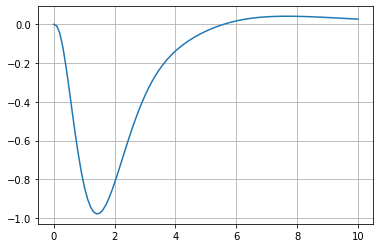

In [274]:
t = np.linspace(0, 10, 100)
t, y = ct.initial_response(closed_loop_w_regulator, X0=[0, 0, 0, 0, 1, 0], T=t)
plt.plot(t, y)
plt.grid()

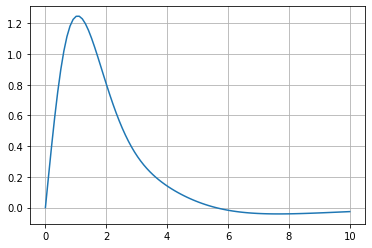

In [277]:
t = np.linspace(0, 10, 100)
t, y = ct.initial_response(closed_loop_w_regulator, X0=[0, 1, 0, 0, 0, 0], T=t)
plt.plot(t, y)
plt.grid()

In [270]:
ct.damp(closed_loop_w_regulator)

_____Eigenvalue______ Damping___ Frequency_
    -4.041                     1      4.041
     1.821    +3.381j    -0.4741       3.84
     1.821    -3.381j    -0.4741       3.84
-7.457e+08                     1  7.457e+08
    -4.077                     1      4.077
    -9.029                     1      9.029


(array([4.04120508e+00, 3.83990317e+00, 3.83990317e+00, 7.45724347e+08,
        4.07692484e+00, 9.02925866e+00]),
 array([ 1.       , -0.4741272, -0.4741272,  1.       ,  1.       ,
         1.       ]),
 array([-4.04120508e+00+0.j        ,  1.82060254e+00+3.38086716j,
         1.82060254e+00-3.38086716j, -7.45724347e+08+0.j        ,
        -4.07692484e+00+0.j        , -9.02925866e+00+0.j        ]))

In [279]:
# y se acabo el tiempo